In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, pearsonr
from scipy.io import loadmat
from sklearn.metrics import r2_score
import seaborn as sns
import h5py

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
from IPython.display import Image, display

In [4]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [5]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [6]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [7]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [8]:
dname = join(dir_git,'Functional_Fusion')
sys.path.append(dname)
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

In [9]:
dname = join(dir_git,'AnatSearchlight')
sys.path.append(dname)
import AnatSearchlight.searchlight as sl

In [10]:
dname = abspath(join(dir_git,'PcmPy'))
sys.path.append(dname)
import PcmPy as pcm

In [11]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import stat as sstat
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [12]:
dir_SSS = su.get_dir_SSS()

In [13]:
dir_roi = su.get_dir_roi()

---

In [14]:
# border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus')
border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser')

In [15]:
hem = 'L'

In [16]:
label_total = ['-']

---

In [17]:
def plot_surf(data, cmap=cm.jet, title=None):
    if isinstance(data, str):
        data = nb.load(data).darrays[0].data
    elif isinstance(surf, nb.gifti.gifti.GiftiImage):
        data = data.darrays[0].data
    elif isinstance(surf, nb.gifti.gifti.GiftiDataArray):
        data = data.data

    g = surf.plot.plotmap(
        data=data,
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap,
        # colorbar=True,
        # cscale=[-1,7],
        # threshold=[-thresh,thresh],
        borders=border, bordercolor='white', bordersize=0.3,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=20, y=220, s=title, ha='center', va='center', fontsize=10)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color='white', fontsize=10)

    return g

---
---

### Hand Area

In [18]:
fname = join(dir_git,'fs_LR_32/BA_handArea.32k.%s.label.gii'%hem)
mask_tmp = nb.load(fname).darrays[0].data

In [19]:
idx = (mask_tmp>0)
mask_sm = np.zeros_like(mask_tmp).astype(int)
mask_sm[idx] = 1

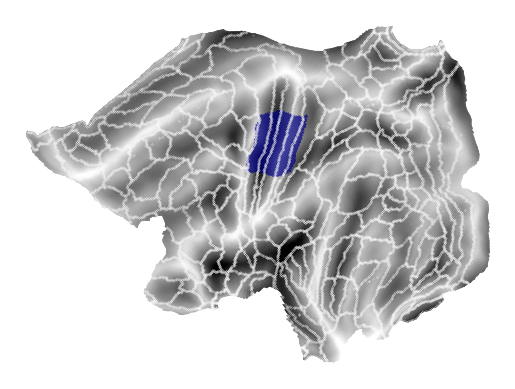

In [20]:
g = plot_surf(mask_sm , cmap=cm.jet)
idx_sm = (mask_sm>0)

### Foveal Area

In [21]:
fname = join(dir_git,'fs_LR_32/Desikan.32k.%s.label.gii'%hem)
mask_tmp = nb.load(fname).darrays[0].data

In [22]:
idx = (mask_tmp==11)
mask_fovea = np.zeros_like(mask_tmp).astype(int)
mask_fovea[idx] = 1

In [23]:
fname = join(dir_git,'fs_LR_32/Wang2015.32k.%s.label.gii'%hem)
mask_tmp = nb.load(fname).darrays[0].data

In [24]:
idx = (mask_tmp>0)
mask_fovea[idx] = 0

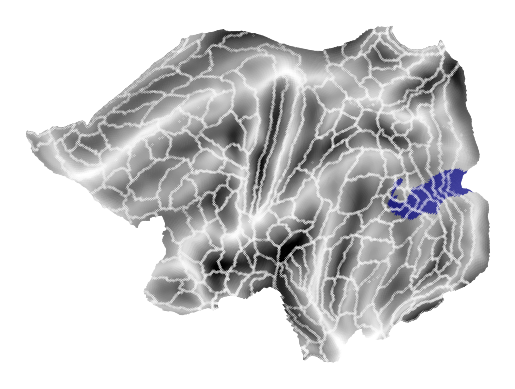

In [25]:
g = plot_surf(mask_fovea , cmap=cm.jet)
idx_fovea = (mask_fovea>0)

### Parafoveal Area

In [26]:
dg = pd.read_csv(join(dir_SSS,'atlas/Wang2015.32k.L.label.txt'), index_col=None, header=0, delimiter='\t')
dg = dg.iloc[:,1:-1]
dg

,KEY,NAME,RED,GREEN,BLUE,ALPHA
0,0,0.000,0.000,0.000,0.000,NaN
1,1,V1v,0.615,0.000,1.000,1.0
2,2,V1d,0.615,1.000,0.000,1.0
3,3,V2v,0.000,1.000,0.308,1.0
4,4,V2d,0.385,0.000,1.000,1.0
5,5,V3v,0.385,1.000,0.000,1.0
6,6,V3d,1.000,0.000,0.462,1.0
7,7,hV4,1.000,0.000,0.231,1.0
8,8,VO1,0.000,1.000,1.000,1.0
9,9,VO2,0.000,1.000,0.538,1.0


In [27]:
fname = join(dir_git,'fs_LR_32/Wang2015.32k.%s.label.gii'%hem)
mask_tmp = nb.load(fname).darrays[0].data

In [28]:
labels = {}
labels['Vd'] = ['V1d','V2d','V3d','LO1','LO2','V3A','V3B']
labels['Vv'] = ['V1v','V2v','V3v','hV4','VO1']
# labels['V3A'] = ['V3A']
# labels['V3B'] = ['V3B']
# labels['IPS0'] = ['IPS0']
mask_Vd = np.zeros_like(mask_tmp)
mask_Vv = np.zeros_like(mask_tmp)
for ii, (roi, names) in enumerate(labels.items()):
    for jj, name in enumerate(names):
        val = int(dg.loc[dg.NAME.str.contains(name,na=False),'KEY'].iloc[0])
        idx = (mask_tmp == val).astype(int)
        if roi=='Vd':
            mask_Vd += idx
        if roi=='Vv':
            mask_Vv += idx
mask_Vd = (mask_Vd>0).astype(int)
mask_Vv = (mask_Vv>0).astype(int)

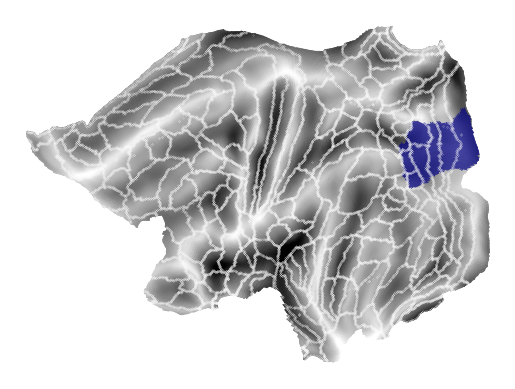

In [29]:
g = plot_surf(mask_Vd , cmap=cm.jet)
idx_Vd = (mask_Vd>0)

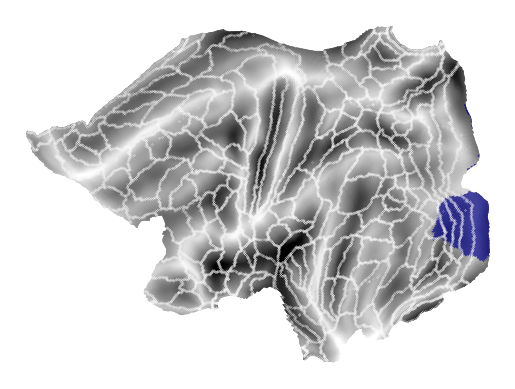

In [30]:
g = plot_surf(mask_Vv , cmap=cm.jet)
idx_Vv= (mask_Vv>0)

---
---

`:%s; \+;\t;g` in `vim`

In [31]:
df = pd.read_csv(join(dir_SSS,'atlas/Glasser_2016.32k.L.label.txt'), index_col=None, header=0, delimiter='\t')
df = df.iloc[:,1:-1]
df

,KEY,NAME,RED,GREEN,BLUE,ALPHA
0,0,???,1.000,1.000,1.000,0.0
1,1,L_V1_ROI,0.247,0.020,1.000,1.0
2,2,L_MST_ROI,0.212,0.404,0.506,1.0
3,3,L_V6_ROI,0.243,0.306,0.698,1.0
4,4,L_V2_ROI,0.090,0.196,0.914,1.0
...,...,...,...,...,...,...
176,176,L_STSva_ROI,0.157,0.129,0.086,1.0
177,177,L_TE1m_ROI,0.231,0.176,0.169,1.0
178,178,L_PI_ROI,0.478,0.196,0.196,1.0
179,179,L_a32pr_ROI,0.510,0.247,0.341,1.0


In [32]:
fname = join(dir_git,'fs_LR_32/Glasser_2016.32k.%s.label.gii'%hem)
gii = nb.load(fname)

In [33]:
mask_orig = gii.darrays[0].data
mask_orig.shape

(32492,)

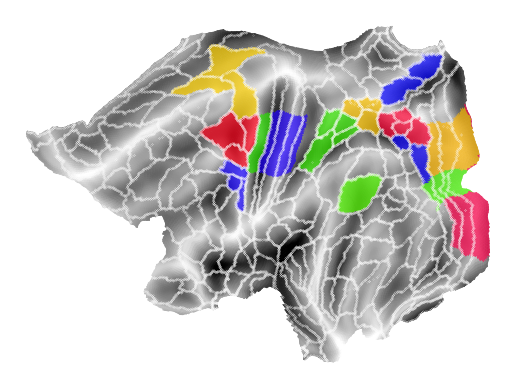

In [34]:
mask_new = np.zeros_like(mask_orig).astype(int)

N = 0
labels = {}
labels['S1'] = ['L_3b_ROI','L_3a_ROI','L_1_ROI','L_2_ROI']
labels['M1'] = ['L_4_ROI']
labels['SMA'] = ['L_SCEF_ROI','L_24dd_ROI','L_6mp_ROI']
labels['PMd'] = ['L_6a_ROI','L_6d_ROI','L_FEF_ROI']
labels['PMv'] = ['L_6v_ROI','L_PEF_ROI','L_55b_ROI']
labels['SPLa'] = ['L_AIP_ROI','L_7PC_ROI','L_LIPv_ROI','L_LIPd_ROI']
labels['SPLp'] = ['L_MIP_ROI','L_VIP_ROI','L_7PL_ROI']
labels['IPS'] = ['L_IPS1_ROI','L_V7_ROI','L_V6A_ROI','L_V3A_ROI']
labels['V4d'] = ['L_V3B_ROI','L_V4_ROI']
# labels['IP'] = ['L_IP1_ROI','L_IP2_ROI','L_LIPd_ROI']
labels['Vf'] = ['L_V1_ROI','L_V2_ROI','L_V3_ROI','L_V4_ROI']
labels['Vd'] = ['L_V1_ROI','L_V2_ROI','L_V3_ROI']
labels['Vv'] = ['L_V1_ROI','L_V2_ROI','L_V3_ROI']
# labels['BA7'] = ['L_7Pm_ROI','L_7Am_ROI','L_7m_ROI']
labels['POS'] = ['L_POS1_ROI','L_POS2_ROI','#L_DVT_ROI']
# labels['TPOJ'] = ['L_TPOJ2_ROI','L_TPOJ3_ROI']
labels['PGi'] = ['L_PGi_ROI']
for ii, (roi, names) in enumerate(labels.items()):
    for jj, name in enumerate(names):
        if name[0]=='#':
            continue
        val = int(df.loc[df.NAME.str.contains(name,na=False),'KEY'].iloc[0])
        idx = mask_orig == val
        if (roi=='S1')|(roi=='M1'):
            idx *= idx_sm
        elif roi=='Vf':
            idx *= idx_fovea
        elif roi=='Vd':
            idx *= idx_Vd
        elif roi=='Vv':
            idx *= idx_Vv
        elif roi=='V4d':
            if name=='L_V4_ROI':
                idx *= idx_Vd
        mask_new[idx] = N+1
    N += 1

cmap = cm.prism.resampled(N+1)
g = plot_surf(mask_new , cmap=cmap)

In [35]:
for ii, key in enumerate(labels.keys()):
    label_total.append(key)
    ## the number of vertecies
    numV = (mask_new == ii+1).sum()
    print(key, numV)

S1 779
M1 277
SMA 693
PMd 653
PMv 302
SPLa 711
SPLp 375
IPS 390
V4d 188
Vf 189
Vd 471
Vv 567
POS 444
PGi 408


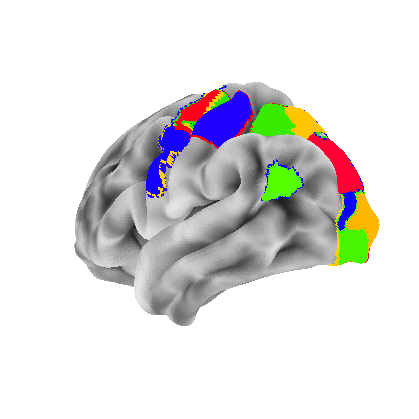

In [36]:
pial = join(dir_git,'fs_LR_32/fs_LR.32k.L.pial.surf.gii')
sulc = join(su.get_dir_surf(),'S01/S01.L.sulc.32k.shape.gii')
elev, azim = 0, 200
g = plotting.plot_surf(
    surf_map=mask_new,
    surf_mesh=pial, bg_map=sulc,
    threshold=0.1,
    cmap=cmap, colorbar=False,
    hemi='left', view=(elev, azim),
    darkness=None,
)

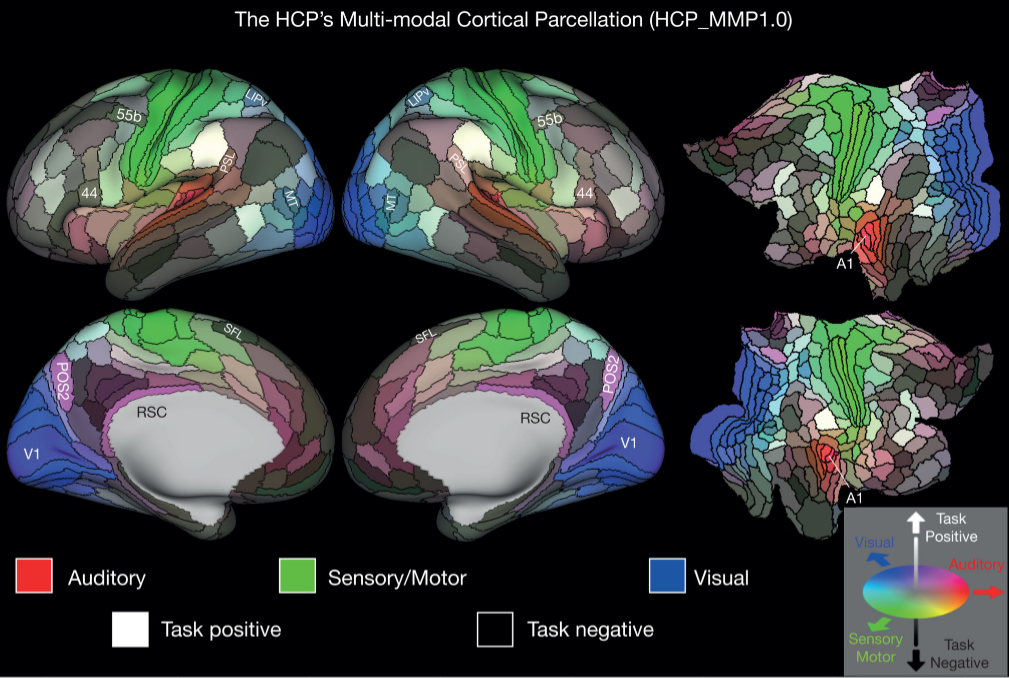

In [37]:
display(Image(filename='../figures/Glasser.png'))

---

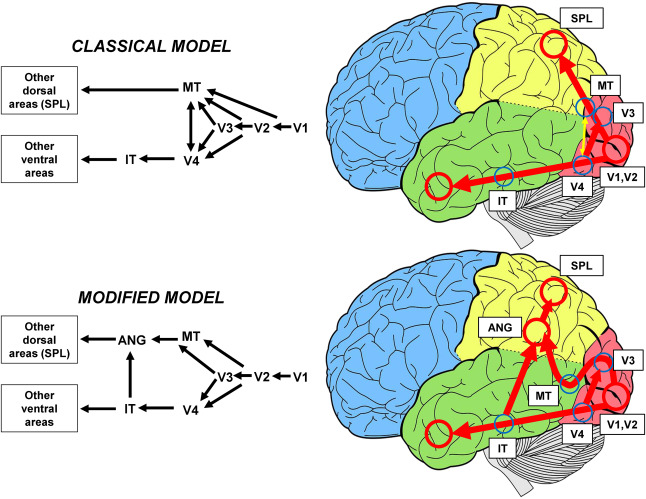

In [38]:
display(Image(filename='../figures/dorsal-and-ventral-stream.jpg'))

### Save the mask as gifti

In [39]:
# GIFTI 데이터 배열 생성 (intent='NIFTI_INTENT_LABEL' 중요!)
data_array = nb.gifti.GiftiDataArray(
    data=mask_new.astype(np.int32),
    intent='NIFTI_INTENT_LABEL'
)
# 메타데이터에 hemisphere 정보 추가
meta = nb.gifti.GiftiMetaData()
meta['AnatomicalStructurePrimary'] = 'CortexLeft'   # 또는 'CortexRight'

In [40]:
# Label Table 생성 (레이블 값과 이름 매핑)
label_table = nb.gifti.GiftiLabelTable()

In [41]:
# N = len(label_total)
# cmap = cm.jet.resampled(N)
# cmap

In [42]:
x = np.linspace(0,1,N+1)
# dx = np.diff(x)[0]
# x = x[1:] - dx*0.5
# np.random.shuffle(x)

In [43]:
# 레이블별 RGB 색상 정의 (0~1 범위)
color_map = {0: [1., 1., 1., 0.]}
for ii, (roi, rgba) in enumerate(zip(label_total[1:],cmap(x))):
    color_map[ii+1] = rgba

In [44]:
for ii, roi in enumerate(label_total):
    r,g,b,a = color_map[ii]
    label = nb.gifti.GiftiLabel(
        key=ii,
        red=r,
        green=g,
        blue=b,
        alpha=a
    )
    label.label = roi
    label_table.labels.append(label)

In [45]:
# GiftiImage 생성
gii = nb.gifti.GiftiImage(darrays=[data_array], labeltable=label_table, meta=meta)

In [46]:
# 저장
nb.save(gii, join(dir_roi,'SPark2025.32k.%s.label.gii'%hem))

### Save the mask as cifti

In [47]:
simage.save_surf2cifti(
    data=mask_new[np.newaxis,:],
    label_axis=['value'],
    dir_output=dir_roi,
    prefix='SPark.32k.%s'%hem,
    type_='dlabel'
)

---